# Performance Benchmarking for KV Drive

#### The goal of these set of experiments is to characterize the variability across platforms in a systematic and consistent way in terms of KV drive. The steps of experiments are as follows,

- Run Stress-ng benchmarks on **one KV drive**;
- Run Stress-ng benchmarks on machine **issdm-6**, and get the "**without limit**" result;
- Find all the **common benchmarks** from both results;
- Calculate the **speedup (normalized value)** of each benchmark based on the one from KV drive (**issdm-6 (without limit) / KV drive**);
- Use **[torpor](https://github.com/ivotron/torpor)** to calculate the best **cpu quota** by minimizing the average speedups. We will later use this parameter to limit the cpu usage in the docker container;
- Run Stress-ng benchmarks in the **constrained docker container** on machine **issdm-6**, and get the "**with limit**" result;
- Calculate the **speedup** based on KV drive again (**issdm-6 (with limit) / KV drive**), then we get a new "**speedup range**", which should be must smaller than the previous one.
- Run a bunch of other benchmarks on both KV drive and constrained docker container to **verify** if they are all within in the later "**speedup range**".
- Make conclusion.

In [1]:
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option("display.max_rows", 8)

First, we load all test data.

In [2]:
df = pd.read_csv('stress-ng/third/torpor-results/alltests.csv')

Let's have a look at the pattern of data.

In [3]:
df.head()

,machine,limits,benchmark,class,lower_is_better,repetition,result
0,issdm-6,with,stressng-cpu-all,cpu,False,1,5.229076
1,issdm-6,with,stressng-cpu-ackermann,cpu,False,1,0.535738
2,issdm-6,with,stressng-cpu-bitops,cpu,False,1,93.397542
3,issdm-6,with,stressng-cpu-callfunc,cpu,False,1,12852.729928
4,issdm-6,with,stressng-cpu-cdouble,cpu,False,1,165.364637


Show all the test machines.

In [4]:
df['machine'].unique()

array(['issdm-6', 't2.micro', 'kv3'], dtype=object)

Define some predicates for **machines** and **limits**

In [5]:
machine_is_issdm_6 = df['machine'] == 'issdm-6'
machine_is_t2_micro = df['machine'] == 't2.micro'
machine_is_kv3 = df['machine'] == 'kv3'

limits_is_with = df['limits'] == 'with'
limits_is_without = df['limits'] == 'without'

Show the number of stress tests on different machines

In [6]:
df_issdm_6_with_limit  = df[machine_is_issdm_6 & limits_is_with]
df_t2_micro_with_limit = df[machine_is_t2_micro & limits_is_with]
df_kv3_without_limit   = df[machine_is_kv3 & limits_is_without]

print(
    len(df_issdm_6_with_limit),                       # machine issdm-6 with limit
    len(df[machine_is_issdm_6 & limits_is_without]),  # machine issdm-6 without limit

    len(df_t2_micro_with_limit),                      # machine t2.micro with limit
    len(df[machine_is_t2_micro & limits_is_without]), # machine t2.micro without limit

    len(df_kv3_without_limit)                         # machine kv3 without limit
)

126 128 129 130 123


Because those **failed benchmarks** are not shown in the result report, we want to know how many common successful stress tests on **the target machine and kv3**.

In [7]:
issdm_6_with_limit_merge_kv3 = pd.merge(df_issdm_6_with_limit, df_kv3_without_limit, how='inner', on='benchmark')
t2_micro_with_limit_merge_kv3 = pd.merge(df_t2_micro_with_limit, df_kv3_without_limit, how='inner', on='benchmark')

print(
    # common successful tests from issdm-6 and kv3
    len(issdm_6_with_limit_merge_kv3),
    
    # common successful tests from t2.micro and kv3
    len(t2_micro_with_limit_merge_kv3)
)

120 122


Read the normalized results.

In [8]:
df_normalized = pd.read_csv('stress-ng/third/torpor-results/alltests_with_normalized_results_1.0.csv')

Show some of the data lines. The normalized value is the speedup based on **kv3**. It becomes a negative value when the benchmark runs on **the target machine** is slower than on **kv3** (slowdown).

In [9]:
df_normalized.head()

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
0,stressng-cpu-all,0.559459,issdm-6,with,cpu,False,1,5.229076,9.346665
1,stressng-cpu-all,0.559459,issdm-6,without,cpu,False,1,73.245089,130.921281
2,stressng-cpu-all,0.559459,t2.micro,with,cpu,False,1,15.199386,27.168007
3,stressng-cpu-all,0.559459,t2.micro,without,cpu,False,1,223.475214,399.448778
4,stressng-cpu-ackermann,1.352526,issdm-6,with,cpu,False,1,0.535738,-2.524603


Show those benchmarks are not both successful completed on **the issdm-6 and kv3**.

In [10]:
df_issdm_6_with_limit[~df_issdm_6_with_limit['benchmark'].isin(issdm_6_with_limit_merge_kv3['benchmark'])]

,machine,limits,benchmark,class,lower_is_better,repetition,result
93,issdm-6,with,stressng-cpu-af-alg,cpu,False,1,2240.135965
103,issdm-6,with,stressng-cpu-numa,cpu,False,1,1.188726
112,issdm-6,with,stressng-cpu-cache-icache,cpu-cache,False,1,24.995858
113,issdm-6,with,stressng-cpu-cache-lockbus,cpu-cache,False,1,75485.873873
117,issdm-6,with,stressng-memory-memfd,memory,False,1,1356.940796
124,issdm-6,with,stressng-memory-vm-rw,memory,False,1,1.905445


Show those benchmarks are not both successful completed on **the t2.micro and kv3**.

In [11]:
df_t2_micro_with_limit[~df_t2_micro_with_limit['benchmark'].isin(t2_micro_with_limit_merge_kv3['benchmark'])]

,machine,limits,benchmark,class,lower_is_better,repetition,result
347,t2.micro,with,stressng-cpu-af-alg,cpu,False,1,6666.401429
359,t2.micro,with,stressng-cpu-rdrand,cpu,False,1,24078.103557
362,t2.micro,with,stressng-cpu-tsc,cpu,False,1,62488.869073
367,t2.micro,with,stressng-cpu-cache-icache,cpu-cache,False,1,38.799627
368,t2.micro,with,stressng-cpu-cache-lockbus,cpu-cache,False,1,72449.252834
372,t2.micro,with,stressng-memory-memfd,memory,False,1,2057.039725
381,t2.micro,with,stressng-memory-vm-rw,memory,False,1,8.296505


We can find the number of benchmarks are **speed-up** and **slowdown**, respectively.

In [12]:
normalized_limits_is_with = df_normalized['limits'] == 'with'
normalized_limits_is_without = df_normalized['limits'] == 'without'

normalized_machine_is_issdm_6 = df_normalized['machine'] == 'issdm-6'
normalized_machine_is_t2_micro = df_normalized['machine'] == 't2.micro'

normalized_is_speed_up = df_normalized['normalized'] > 0
normalized_is_slow_down = df_normalized['normalized'] < 0

print(
    # issdm-6 without CPU restriction
    len(df_normalized[normalized_limits_is_without & normalized_machine_is_issdm_6 & normalized_is_speed_up]),   # 1. speed-up
    len(df_normalized[normalized_limits_is_without & normalized_machine_is_issdm_6 & normalized_is_slow_down]),  # 2. slowdown
    
    # issdm-6 with CPU restriction
    len(df_normalized[normalized_limits_is_with & normalized_machine_is_issdm_6 & normalized_is_speed_up]),      # 3. speed-up
    len(df_normalized[normalized_limits_is_with & normalized_machine_is_issdm_6 & normalized_is_slow_down]),     # 4. slowdown
    
    # t2.micro without CPU restriction
    len(df_normalized[normalized_limits_is_without & normalized_machine_is_t2_micro & normalized_is_speed_up]),  # 5. speed-up
    len(df_normalized[normalized_limits_is_without & normalized_machine_is_t2_micro & normalized_is_slow_down]), # 6. slowdown
    
    # t2.micro with CPU restriction
    len(df_normalized[normalized_limits_is_with & normalized_machine_is_t2_micro & normalized_is_speed_up]),     # 7. speed-up
    len(df_normalized[normalized_limits_is_with & normalized_machine_is_t2_micro & normalized_is_slow_down])     # 8. slowdown
)

116 5 51 69 119 3 66 56


The **average of normalized value** for results under CPU restriction

In [13]:
print(
    # For issdm-6
    df_normalized[normalized_machine_is_issdm_6 & normalized_limits_is_with]['normalized'].mean(),
    
    # For t2_micro
    df_normalized[normalized_machine_is_t2_micro & normalized_limits_is_with]['normalized'].mean()
)

-1.09297401539 -52.1770441208


### Experiment Results from issdm-6

Let's have a look at the **histogram of frequency of normalized value** based on ** stress tests without CPU restriction running on issdm-6**.

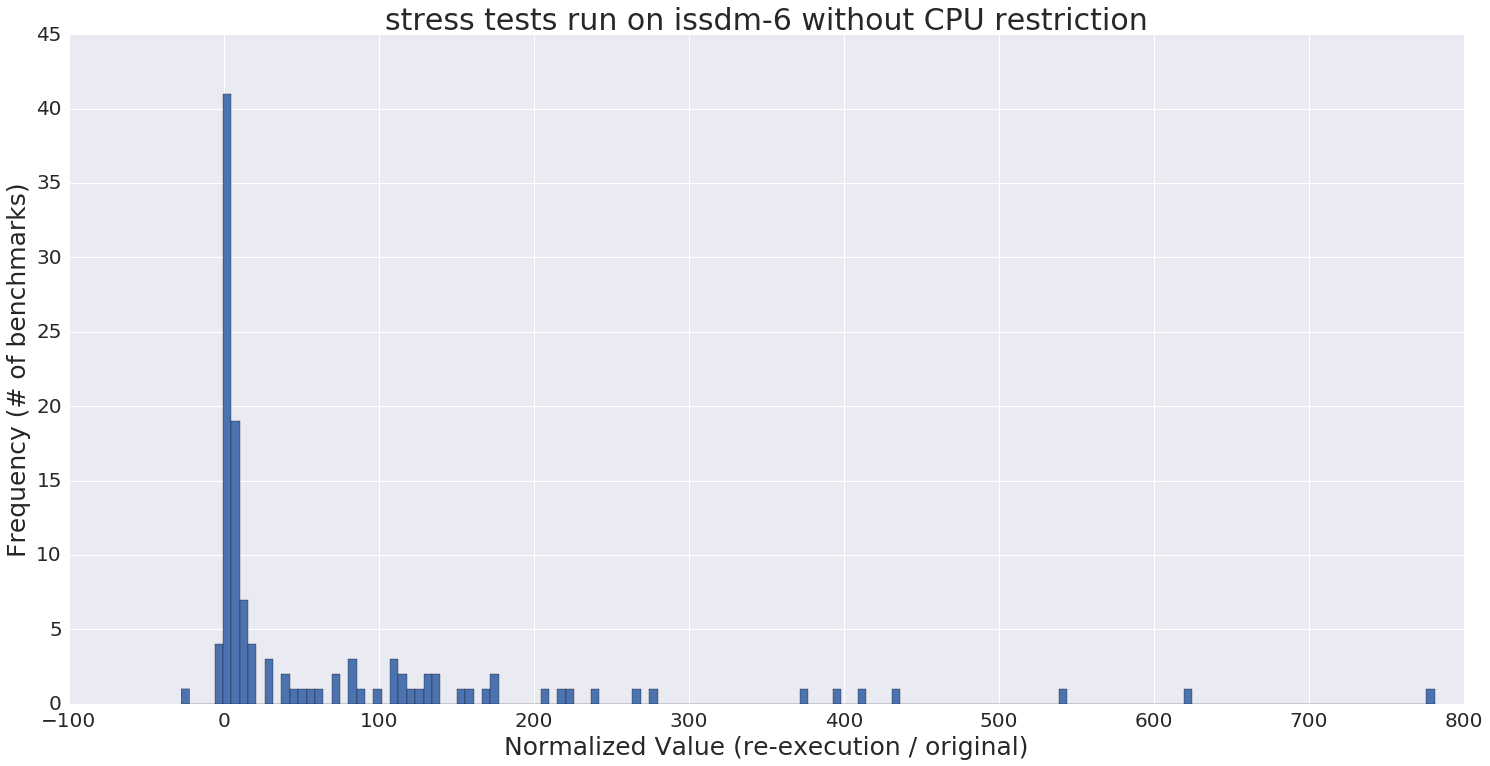

In [14]:
df_normalized_issdm_6_without_limit = df_normalized[normalized_machine_is_issdm_6 & normalized_limits_is_without]
df_normalized_issdm_6_without_limit.normalized.hist(bins=150, figsize=(25,12), xlabelsize=20, ylabelsize=20)

plt.title('stress tests run on issdm-6 without CPU restriction', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

Here is the **rank of normalized value** from stress tests **without CPU restriction**

In [15]:
df_normalized_issdm_6_without_limit_sorted = df_normalized_issdm_6_without_limit.sort_values(by='normalized', ascending=0)
df_normalized_issdm_6_without_limit_sorted_head = df_normalized_issdm_6_without_limit_sorted.head()
df_normalized_issdm_6_without_limit_sorted_tail = df_normalized_issdm_6_without_limit_sorted.tail()
df_normalized_issdm_6_without_limit_sorted_head.append(df_normalized_issdm_6_without_limit_sorted_tail)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
261,stressng-cpu-sqrt,5.172518,issdm-6,without,cpu,False,1,4041.087860,781.261246
85,stressng-cpu-gamma,0.196768,issdm-6,without,cpu,False,1,122.810914,624.140683
205,stressng-cpu-nsqrt,0.170864,issdm-6,without,cpu,False,1,92.667529,542.346714
61,stressng-cpu-euler,8422.503460,issdm-6,without,cpu,False,1,3668571.085120,435.567774
...,...,...,...,...,...,...,...,...,...
437,stressng-cpu-cache-cache,32.907173,issdm-6,without,cpu-cache,False,1,22.300178,-1.475646
353,stressng-string-strncasecmp,11272.022718,issdm-6,without,string,False,1,6306.289926,-1.787425
325,stressng-string-strcasecmp,13468.776467,issdm-6,without,string,False,1,6318.336606,-2.131697
181,stressng-cpu-jenkin,470339.193258,issdm-6,without,cpu,False,1,17101.863912,-27.502218


Now let's have a look at the **histogram of frequency of normalized value** based on ** stress tests with CPU restriction running on issdm-6**.

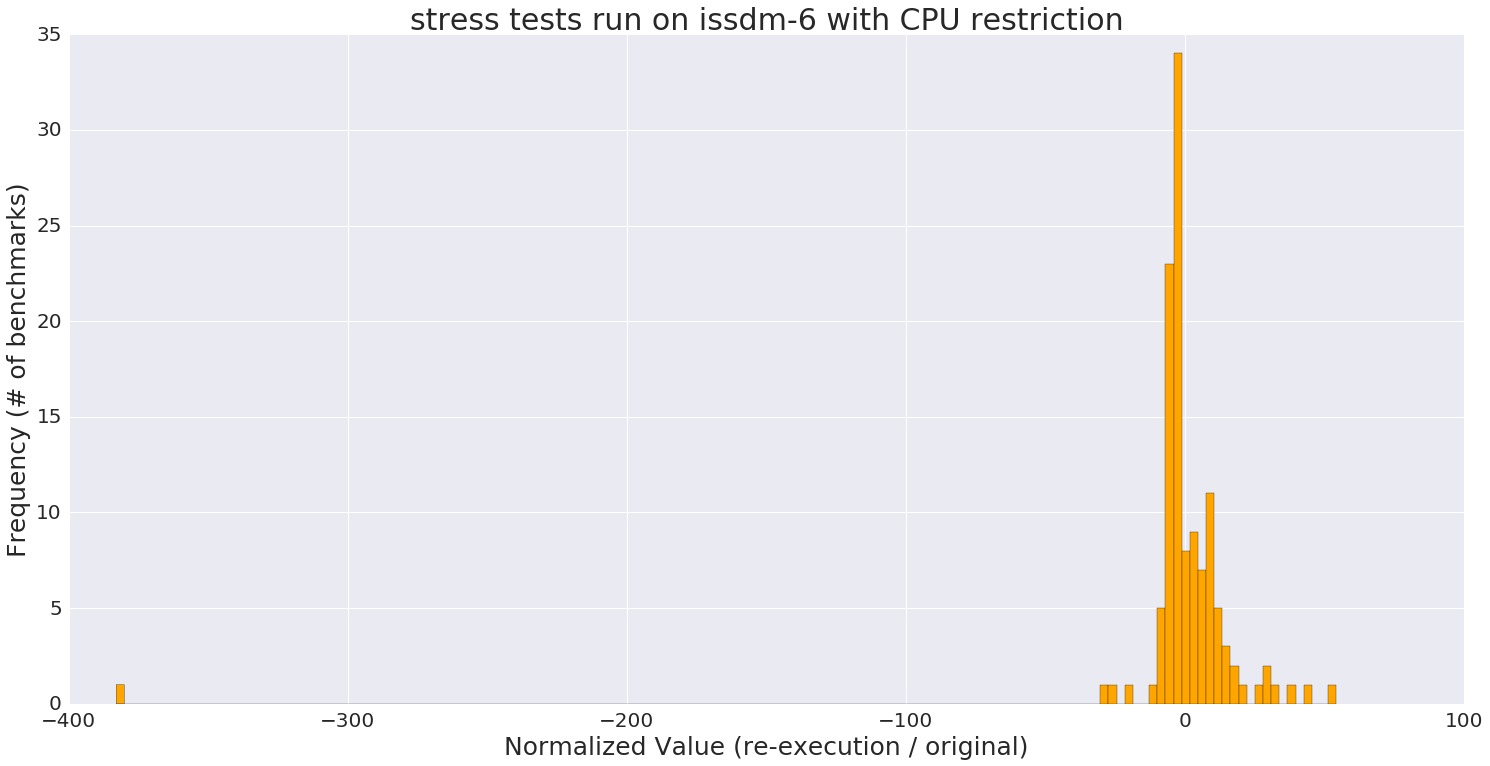

In [16]:
df_normalized_issdm_6_with_limit = df_normalized[normalized_machine_is_issdm_6 & normalized_limits_is_with]
df_normalized_issdm_6_with_limit.normalized.hist(color='Orange', bins=150, figsize=(25,12), xlabelsize=20, ylabelsize=20)

plt.title('stress tests run on issdm-6 with CPU restriction', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

Here is the **rank of normalized value** from stress tests **with CPU restriction**

In [17]:
df_normalized_issdm_6_with_limit_sorted = df_normalized_issdm_6_with_limit.sort_values(by='normalized', ascending=0)
df_normalized_issdm_6_with_limit_sorted_head = df_normalized_issdm_6_with_limit_sorted.head()
df_normalized_issdm_6_with_limit_sorted_tail = df_normalized_issdm_6_with_limit_sorted.tail()
df_normalized_issdm_6_with_limit_sorted_head.append(df_normalized_issdm_6_with_limit_sorted_tail)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
260,stressng-cpu-sqrt,5.172518,issdm-6,with,cpu,False,1,280.696748,54.266945
84,stressng-cpu-gamma,0.196768,issdm-6,with,cpu,False,1,8.898357,45.222582
204,stressng-cpu-nsqrt,0.170864,issdm-6,with,cpu,False,1,6.699748,39.210998
60,stressng-cpu-euler,8422.503460,issdm-6,with,cpu,False,1,263206.984608,31.250445
...,...,...,...,...,...,...,...,...,...
436,stressng-cpu-cache-cache,32.907173,issdm-6,with,cpu-cache,False,1,1.600015,-20.566790
352,stressng-string-strncasecmp,11272.022718,issdm-6,with,string,False,1,449.198875,-25.093613
324,stressng-string-strcasecmp,13468.776467,issdm-6,with,string,False,1,458.204632,-29.394675
180,stressng-cpu-jenkin,470339.193258,issdm-6,with,cpu,False,1,1227.934894,-383.032680


We notice that the **stressng-cpu-jenkin** looks like an outlier. Let's redraw the histogram without this one.

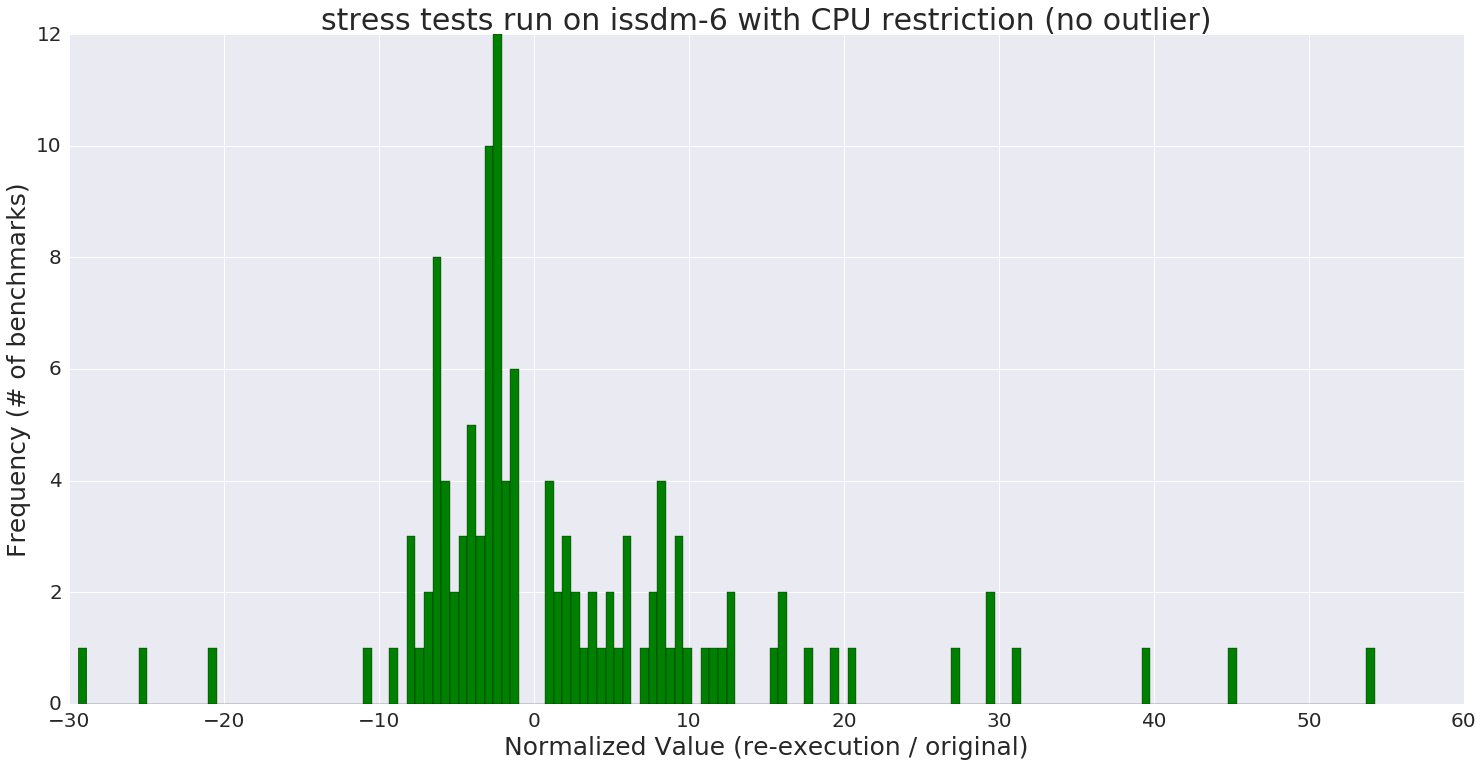

In [18]:
df_normalized_issdm_6_no_outlier = df_normalized_issdm_6_with_limit['benchmark'] != 'stressng-cpu-jenkin'
df_normalized_issdm_6_with_limit[df_normalized_issdm_6_no_outlier].normalized.hist(color='Green', bins=150, figsize=(25,12), xlabelsize=20, ylabelsize=20)

plt.title('stress tests run on issdm-6 with CPU restriction (no outlier)', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

### Summary

##### We got the boundary of normalized value on issdm-6 from -29.394675 to 54.266945 by using parameters --cpuset-cpus=1 --cpu-quota=7234 --cpu-period=100000, which means the docker container only uses 7.234ms CPU worth of run-time every 100ms on cpu 1 (See [cpu](https://access.redhat.com/documentation/en-US/Red_Hat_Enterprise_Linux/6/html/Resource_Management_Guide/sec-cpu.html) for more details).

### Experiment Results from t2.micro

Let's have a look at the **histogram of frequency of normalized value** based on ** stress tests without CPU restriction running on t2.micro**.

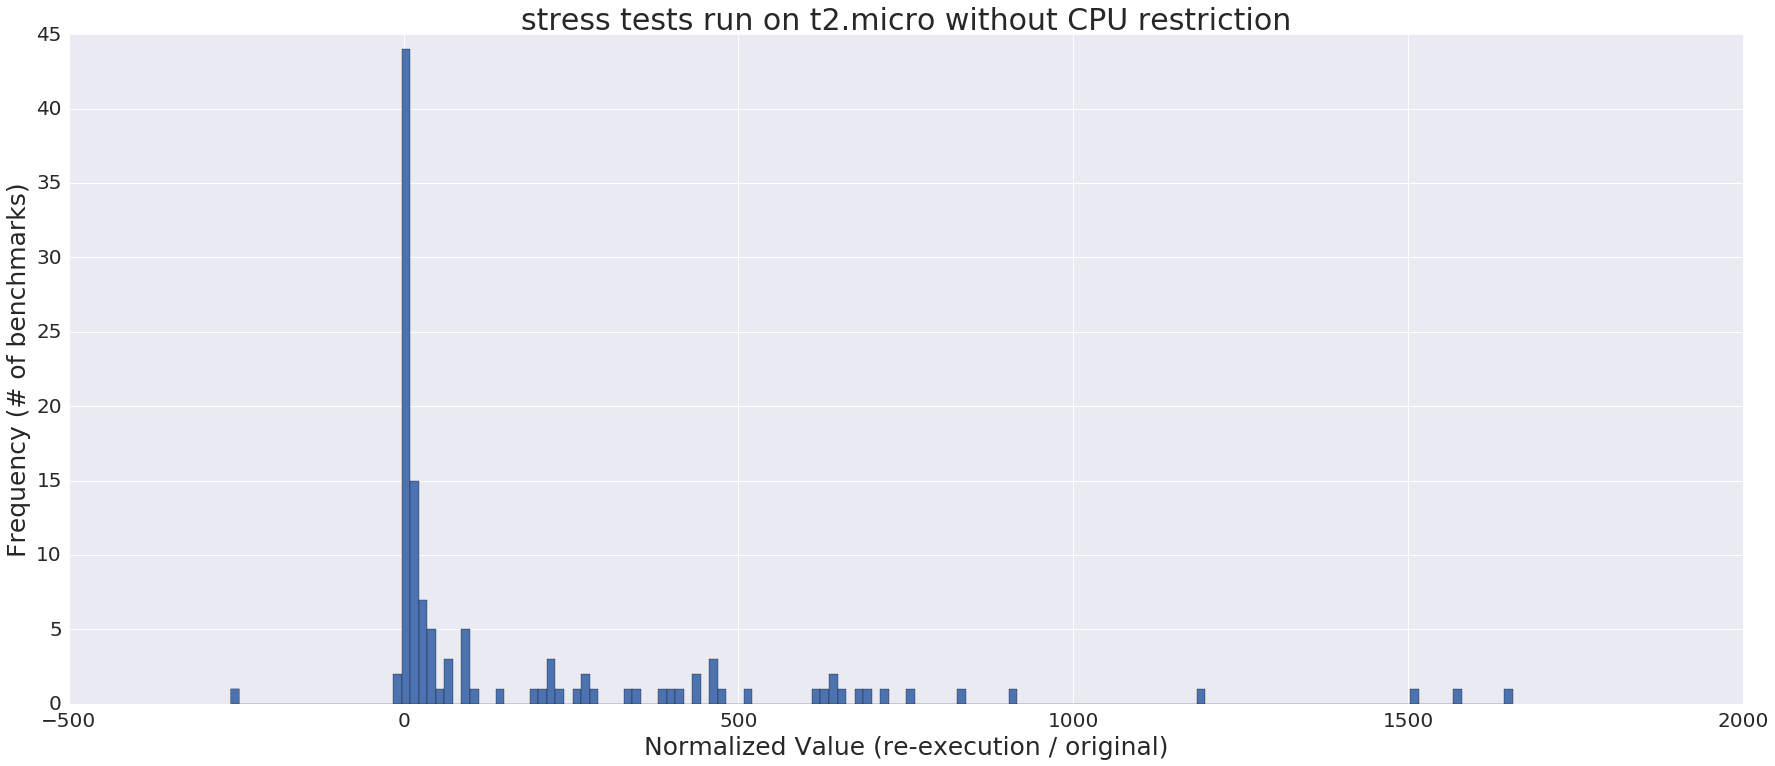

In [19]:
df_normalized_t2_micro_without_limit = df_normalized[normalized_machine_is_t2_micro & normalized_limits_is_without]
df_normalized_t2_micro_without_limit.normalized.hist(bins=150,figsize=(30,12), xlabelsize=20, ylabelsize=20)

plt.title('stress tests run on t2.micro without CPU restriction', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

Here is the **rank of normalized value** from stress tests **without CPU restriction**

In [20]:
df_normalized_t2_micro_without_limit_sorted = df_normalized_t2_micro_without_limit.sort_values(by='normalized', ascending=0)
df_normalized_t2_micro_without_limit_sorted_head = df_normalized_t2_micro_without_limit_sorted.head()
df_normalized_t2_micro_without_limit_sorted_tail = df_normalized_t2_micro_without_limit_sorted.tail()
df_normalized_t2_micro_without_limit_sorted_head.append(df_normalized_t2_micro_without_limit_sorted_tail)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
87,stressng-cpu-gamma,0.196768,t2.micro,without,cpu,False,1,325.956029,1656.549993
263,stressng-cpu-sqrt,5.172518,t2.micro,without,cpu,False,1,8127.805628,1571.344097
203,stressng-cpu-matrixprod,0.126767,t2.micro,without,cpu,False,1,190.777126,1504.943132
299,stressng-matrix-mean,190.142614,t2.micro,without,matrix,False,1,225858.886808,1187.839391
...,...,...,...,...,...,...,...,...,...
423,stressng-cpu-stream,4.620318,t2.micro,without,cpu,False,1,6.094187,1.318997
439,stressng-cpu-cache-cache,32.907173,t2.micro,without,cpu-cache,False,1,2.699978,-12.187941
183,stressng-cpu-jenkin,470339.193258,t2.micro,without,cpu,False,1,32828.454833,-14.327180
472,stressng-memory-stack,9550.063278,t2.micro,without,memory,False,1,36.975041,-258.284048


Let's have a look at the **histogram of frequency of normalized value** based on ** stress tests with CPU restriction running on t2.micro**.

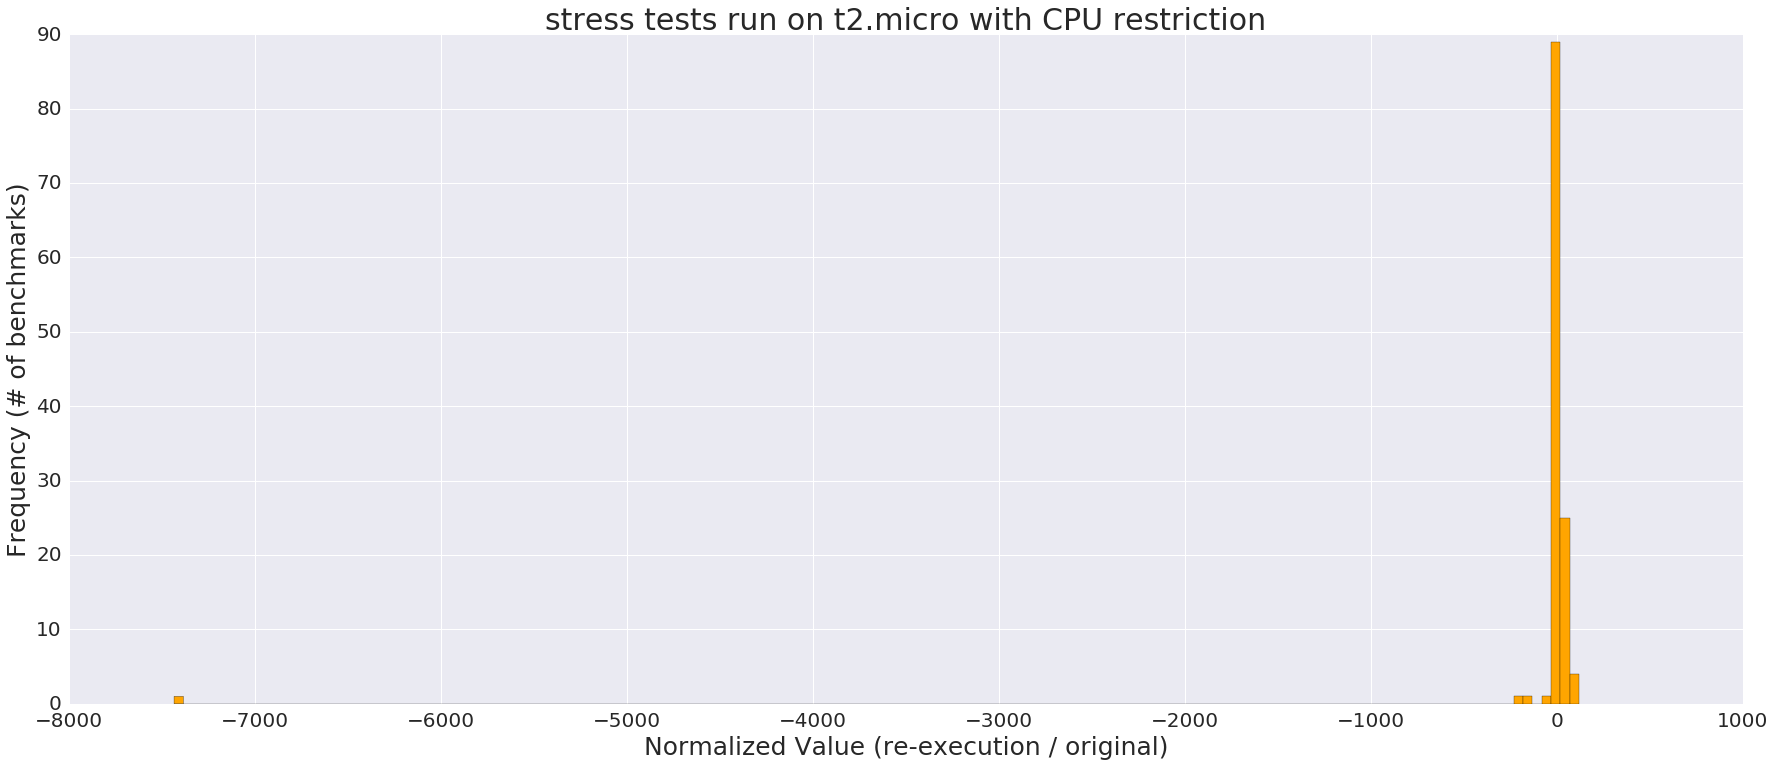

In [21]:
df_normalized_t2_micro_with_limit = df_normalized[normalized_machine_is_t2_micro & normalized_limits_is_with]
df_normalized_t2_micro_with_limit.normalized.hist(color='Orange', bins=150, figsize=(30,12), xlabelsize=20, ylabelsize=20)

plt.title('stress tests run on t2.micro with CPU restriction', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

Here is the **rank of normalized value** from stress tests **with CPU restriction**

In [22]:
df_normalized_t2_micro_with_limit_sorted = df_normalized_t2_micro_with_limit.sort_values(by='normalized', ascending=0)
df_normalized_t2_micro_with_limit_sorted_head = df_normalized_t2_micro_with_limit_sorted.head()
df_normalized_t2_micro_with_limit_sorted_tail = df_normalized_t2_micro_with_limit_sorted.tail()
df_normalized_t2_micro_with_limit_sorted_head.append(df_normalized_t2_micro_with_limit_sorted_tail)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
86,stressng-cpu-gamma,0.196768,t2.micro,with,cpu,False,1,23.593420,119.904761
262,stressng-cpu-sqrt,5.172518,t2.micro,with,cpu,False,1,584.293272,112.961090
202,stressng-cpu-matrixprod,0.126767,t2.micro,with,cpu,False,1,13.663222,107.782167
298,stressng-matrix-mean,190.142614,t2.micro,with,matrix,False,1,15812.388056,83.160675
...,...,...,...,...,...,...,...,...,...
422,stressng-cpu-stream,4.620318,t2.micro,with,cpu,False,1,0.086200,-53.599977
438,stressng-cpu-cache-cache,32.907173,t2.micro,with,cpu-cache,False,1,0.198139,-166.081251
182,stressng-cpu-jenkin,470339.193258,t2.micro,with,cpu,False,1,2370.177001,-198.440535
471,stressng-memory-stack,9550.063278,t2.micro,with,memory,False,1,1.284595,-7434.298964


We notice that the **stressng-memory-stack** looks like an outlier. Let's redraw the histogram without this one.

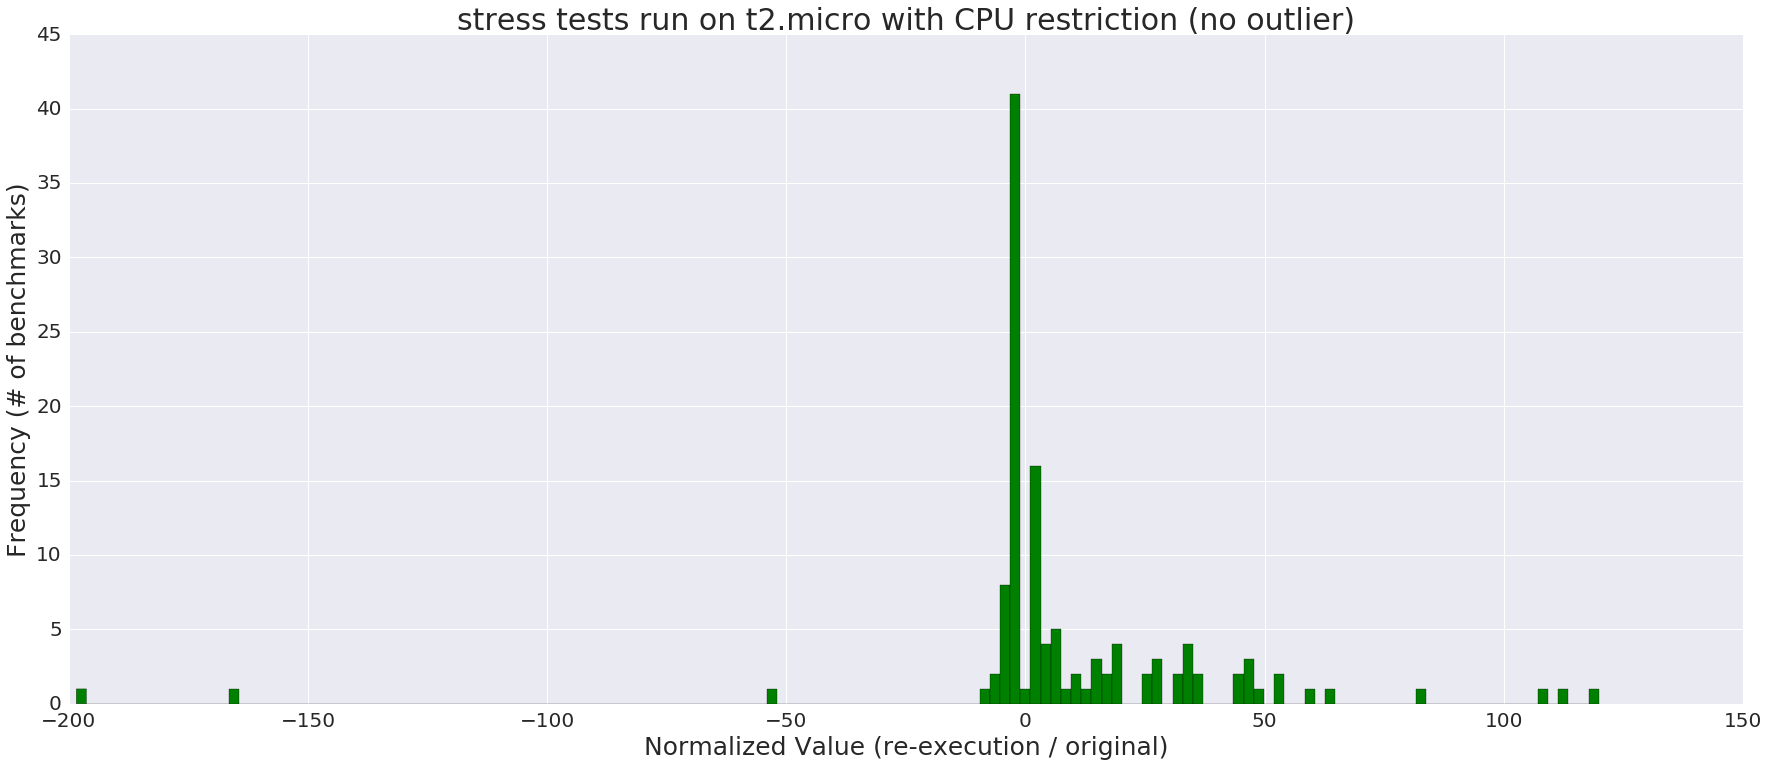

In [23]:
df_normalized_t2_micro_no_outlier = df_normalized_t2_micro_with_limit['benchmark'] != 'stressng-memory-stack'
df_normalized_t2_micro_with_limit[df_normalized_t2_micro_no_outlier].normalized.hist(color='Green', bins=150, figsize=(30,12), xlabelsize=20, ylabelsize=20)

plt.title('stress tests run on t2.micro with CPU restriction (no outlier)', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

The **stressng-cpu-jenkin** benchmark is a collection of (non-cryptographic) hash functions for multi-byte keys. See [Jenkins hash function](https://en.wikipedia.org/wiki/Jenkins_hash_function) from Wikipedia for more details.

### Summary

##### We got the boundary of normalized value **on t2.micro from -198.440535 to 119.904761** by using parameters **--cpuset-cpus=0 --cpu-quota=25750 --cpu-period=100000**, which means the docker container only uses **7.234ms CPU worth of run-time every 100ms on cpu 0** (See [cpu](https://access.redhat.com/documentation/en-US/Red_Hat_Enterprise_Linux/6/html/Resource_Management_Guide/sec-cpu.html) for more details).

### Verification

Now we use **9** other benchmark programs to verify this result. These programs are,
- **blogbench**: filesystem benchmark.
- **compilebench**: It tries to age a filesystem by simulating some of the disk IO common in creating, compiling, patching, stating and reading kernel trees.
- **fhourstones**: This integer benchmark solves positions in the game of connect-4.
- **himeno**: Himeno benchmark score is affected by the performance of a computer, especially memory band width. This benchmark program takes measurements to proceed major loops in solving the Poisson’s equation solution using the Jacobi iteration method.
- **interbench**: It is designed to measure the effect of changes in Linux kernel design or system configuration changes such as cpu, I/O scheduler and filesystem changes and options.
- **nbench**: NBench([Wikipedia](https://en.wikipedia.org/wiki/NBench)) is a synthetic computing benchmark program developed in the mid-1990s by the now defunct BYTE magazine intended to measure a computer's CPU, FPU, and Memory System speed.
- **pybench**: It is a collection of tests that provides a standardized way to measure the performance of Python implementations.
- **ramsmp**: RAMspeed is a free open source command line utility to measure cache and memory performance of computer systems.
- **stockfish-7**: It is a simple benchmark by letting Stockfish analyze a set of positions for a given limit each.

Read verification tests data.

In [24]:
df_verification = pd.read_csv('verification/results/2/alltests_with_normalized_results_1.0.csv')

Show number of test benchmarks.

In [25]:
len(df_verification) / 2

174.0

Order the test results by the **absolute of normalized value**

In [26]:
df_verification_rank = df_verification.reindex(df_verification.normalized.abs().sort_values(ascending=0).index)
df_verification_rank.head(8)

,machine,limits,benchmark,base_result,lower_is_better,result,normalized
81,t2.micro,with,nbench_neural_net,0.23485,False,99.331,422.955078
85,t2.micro,with,nbench_floating-point_index,0.16700,False,55.600,332.934132
82,t2.micro,with,nbench_lu_decomposition,7.89580,False,2608.200,330.327516
77,t2.micro,with,nbench_fourier,155.53000,False,41088.000,264.180544
69,issdm-6,with,nbench_lu_decomposition,7.89580,False,1123.900,142.341498
68,issdm-6,with,nbench_neural_net,0.23485,False,32.941,140.263998
72,issdm-6,with,nbench_floating-point_index,0.16700,False,22.106,132.371257
64,issdm-6,with,nbench_fourier,155.53000,False,18073.000,116.202662


### Verification Tests on issdm-6

Histogram of frequency of normalized value.

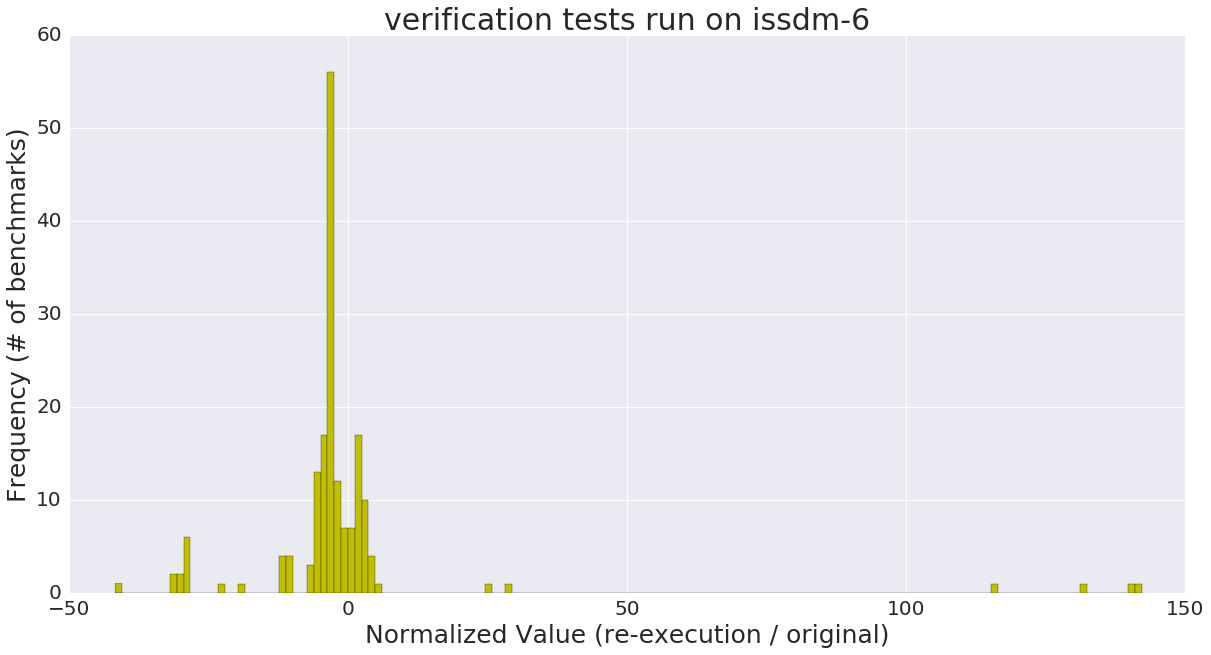

In [27]:
df_verification_issdm_6 = df_verification[df_verification['machine'] == 'issdm-6']
df_verification_issdm_6.normalized.hist(color='y', bins=150,figsize=(20,10), xlabelsize=20, ylabelsize=20)

plt.title('verification tests run on issdm-6', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

Print the **max** the **min** normalized value,

In [28]:
print(
    df_verification_issdm_6['normalized'].max(),
    df_verification_issdm_6['normalized'].min()
)

142.341498012 -41.7032315446


The **average of noramlized value** is,

In [29]:
df_verification_issdm_6['normalized'].mean()

-0.88437898554052508

If we remove all **nbench** tests, the frequency histogram changes to

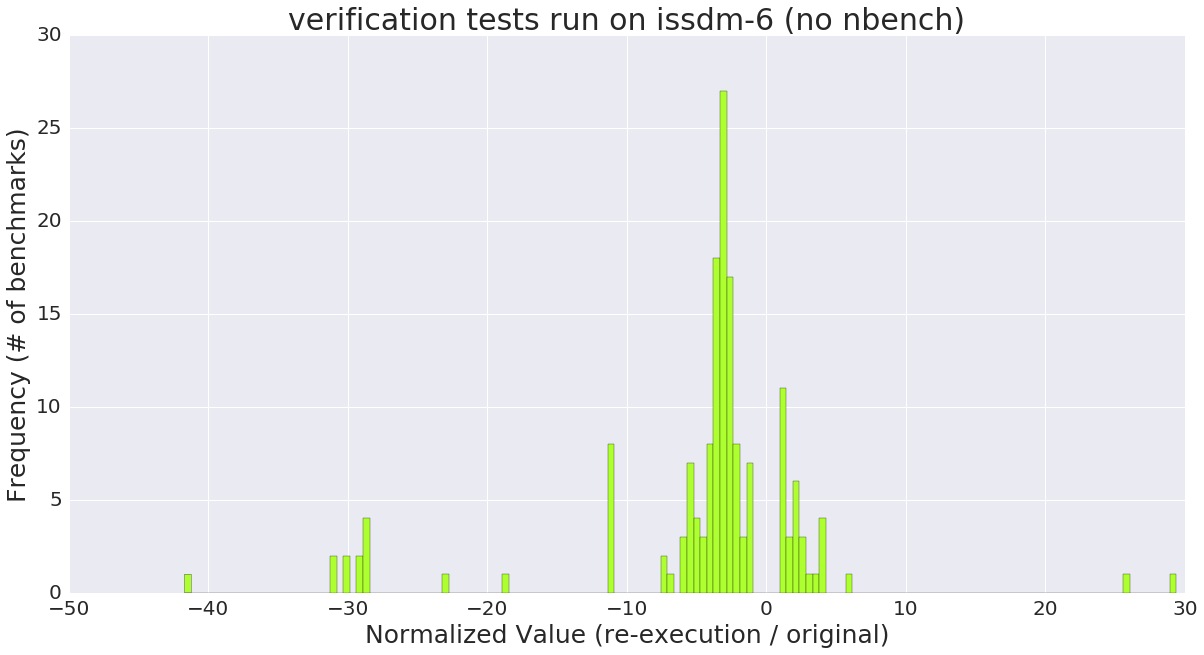

In [30]:
df_verification_issdm_6_no_nbench = df_verification_issdm_6[~df_verification_issdm_6['benchmark'].str.startswith('nbench')]
df_verification_issdm_6_no_nbench.normalized.hist(color='greenyellow', bins=150,figsize=(20,10), xlabelsize=20, ylabelsize=20)

plt.title('verification tests run on issdm-6 (no nbench)', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

The **max** the **min** normalized value changes to,

In [31]:
print(
    df_verification_issdm_6_no_nbench['normalized'].max(),
    df_verification_issdm_6_no_nbench['normalized'].min()
)

29.3846153846 -41.7032315446


The **average of noramlized value** changes to,

In [32]:
df_verification_issdm_6_no_nbench['normalized'].mean()

-4.4025507445284484

### Verification Tests on t2.micro

Histogram of frequency of normalized value.

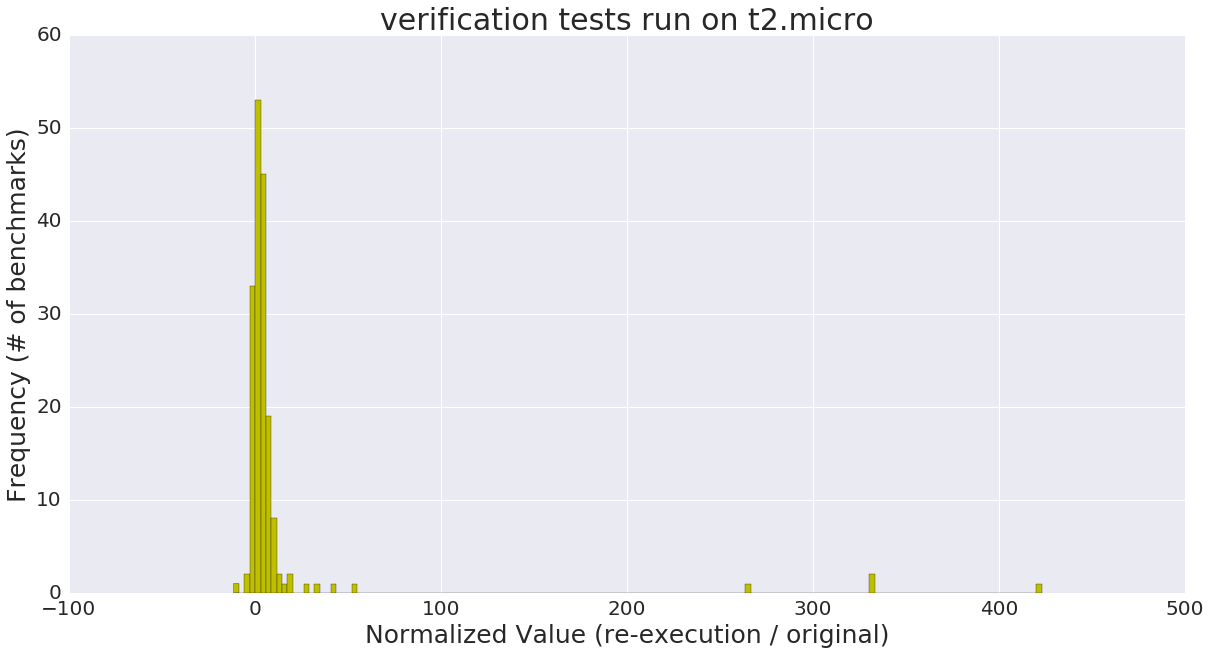

In [33]:
df_verification_t2_micro = df_verification[df_verification['machine'] == 't2.micro']
df_verification_t2_micro.normalized.hist(color='y', bins=150,figsize=(20,10), xlabelsize=20, ylabelsize=20)

plt.title('verification tests run on t2.micro', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

The **average of noramlized value** of the **verification benchmarks** is,

In [34]:
df_verification_t2_micro['normalized'].mean()

11.875728812510811

Let's see the frequency histogram after removing right-most four outliers.

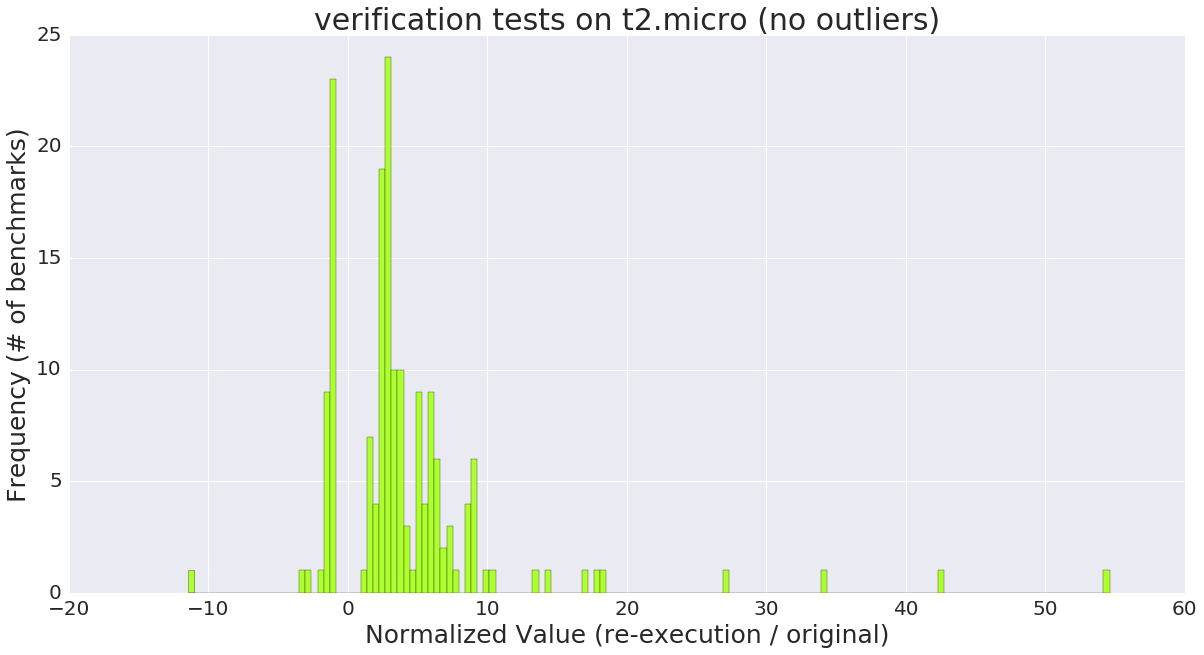

In [35]:
df_verification_top_benchmakrs = df_verification_rank[df_verification_rank['machine'] == 't2.micro'].head(4)['benchmark']
df_verification_t2_micro_no_outliers = df_verification_t2_micro[~df_verification_t2_micro['benchmark'].isin(df_verification_top_benchmakrs)]

df_verification_t2_micro_no_outliers.normalized.hist(color='greenyellow', bins=150,figsize=(20,10), xlabelsize=20, ylabelsize=20)

plt.title('verification tests on t2.micro (no outliers)', fontsize=30)

plt.xlabel('Normalized Value (re-execution / original)', fontsize=25)
plt.ylabel('Frequency (# of benchmarks)', fontsize=25)

Print the **max** the **min** normalized value,

In [36]:
print(
    df_verification_t2_micro_no_outliers['normalized'].max(),
    df_verification_t2_micro_no_outliers['normalized'].min()
)

54.6037771386 -11.4088162537


The **average of noramlized value** without the four outliners is,

In [37]:
df_verification_t2_micro_no_outliers['normalized'].mean()

4.2116443770008614